
***Dataset***

The dataset consists of feature vectors belonging to **12,330 sessions**.
The dataset was formed so that each session
would belong to a different user in a 1-year period to avoid
any tendency to a specific campaign, special day, user
profile, or period.

The dataset consists of **10** **numerical** and **8** categorical attributes.
The '***Revenue***' attribute can be used as the class label.

Additional informations about the dataset such as how the data collected, can be found on the following URL:
http://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

In [187]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [188]:
data = pd.read_csv("online_shoppers_intention.csv")

# Data Exploration

In [189]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [190]:
data["Revenue"].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [191]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

We checked unique values of each feature to get better understanding of features type.

In [192]:
number_of_unique_values = []

for col in data.columns:
    number_of_unique_values.append(data[col].unique().size)

unique_values_df = pd.DataFrame({"Columns": data.columns,
                                 "Unique Values": number_of_unique_values})
print(unique_values_df)

                    Columns  Unique Values
0            Administrative             27
1   Administrative_Duration           3335
2             Informational             17
3    Informational_Duration           1258
4            ProductRelated            311
5   ProductRelated_Duration           9551
6               BounceRates           1872
7                 ExitRates           4777
8                PageValues           2704
9                SpecialDay              6
10                    Month             10
11         OperatingSystems              8
12                  Browser             13
13                   Region              9
14              TrafficType             20
15              VisitorType              3
16                  Weekend              2
17                  Revenue              2


We assigned appropriate types to features.

In [193]:
data.VisitorType = data.VisitorType.astype("category")
data.TrafficType = data.TrafficType.astype("category")
data.Region = data.Region.astype("category")
data.Browser = data.Browser.astype("category")
data.OperatingSystems = data.OperatingSystems.astype("category")
data.Month = data.Month.astype("category")
data.SpecialDay = data.SpecialDay.astype("category")

data.Weekend = data.Weekend.astype("int")
data.Revenue = data.Revenue.astype("int")

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           12330 non-null  int64   
 1   Administrative_Duration  12330 non-null  float64 
 2   Informational            12330 non-null  int64   
 3   Informational_Duration   12330 non-null  float64 
 4   ProductRelated           12330 non-null  int64   
 5   ProductRelated_Duration  12330 non-null  float64 
 6   BounceRates              12330 non-null  float64 
 7   ExitRates                12330 non-null  float64 
 8   PageValues               12330 non-null  float64 
 9   SpecialDay               12330 non-null  category
 10  Month                    12330 non-null  category
 11  OperatingSystems         12330 non-null  category
 12  Browser                  12330 non-null  category
 13  Region                   12330 non-null  category
 14  Traffi

In [195]:
data.duplicated().value_counts()

False    12205
True       125
dtype: int64

In [196]:
data.drop_duplicates(inplace=True,ignore_index= True)

## Missing Value Examination

<AxesSubplot:>

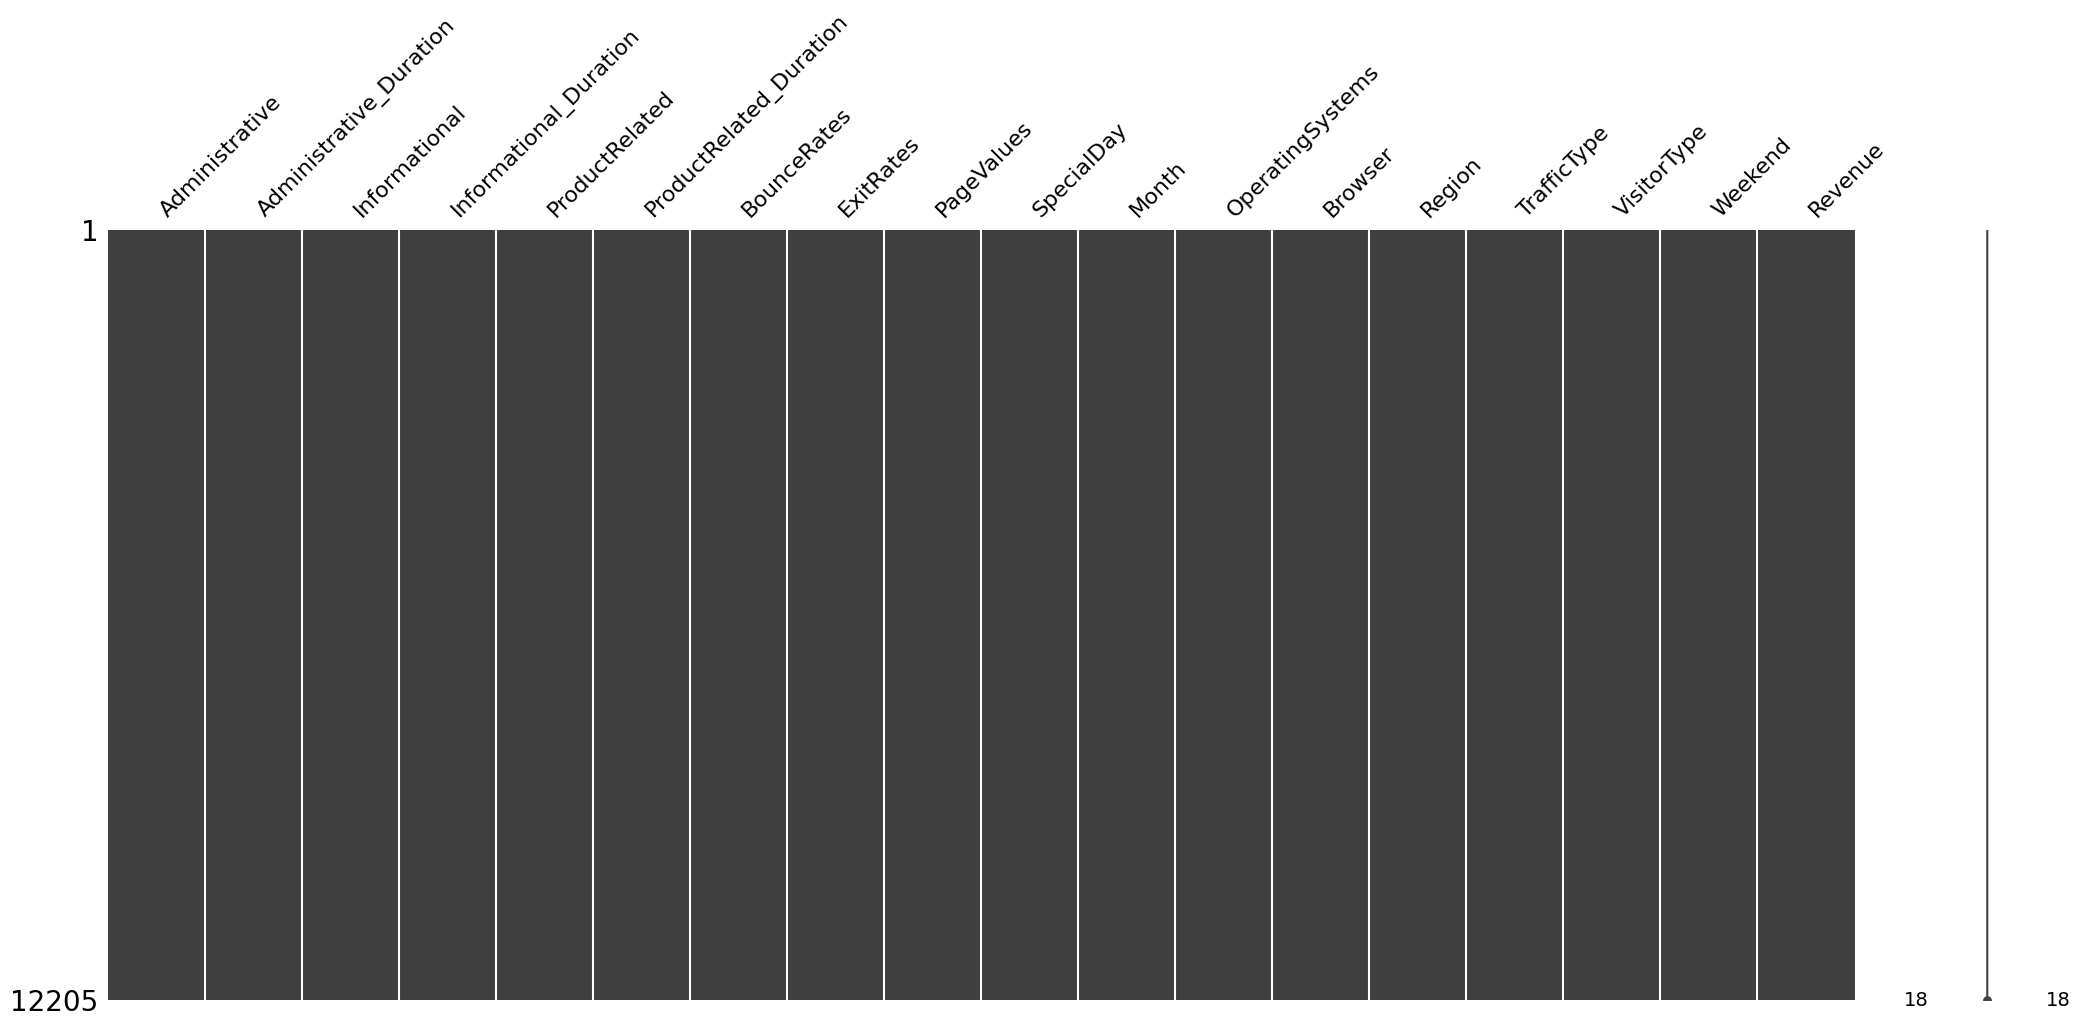

In [197]:
msno.matrix(data)

As you can see there is not any missing values in the dataset.

# Data Visualization

<AxesSubplot:>

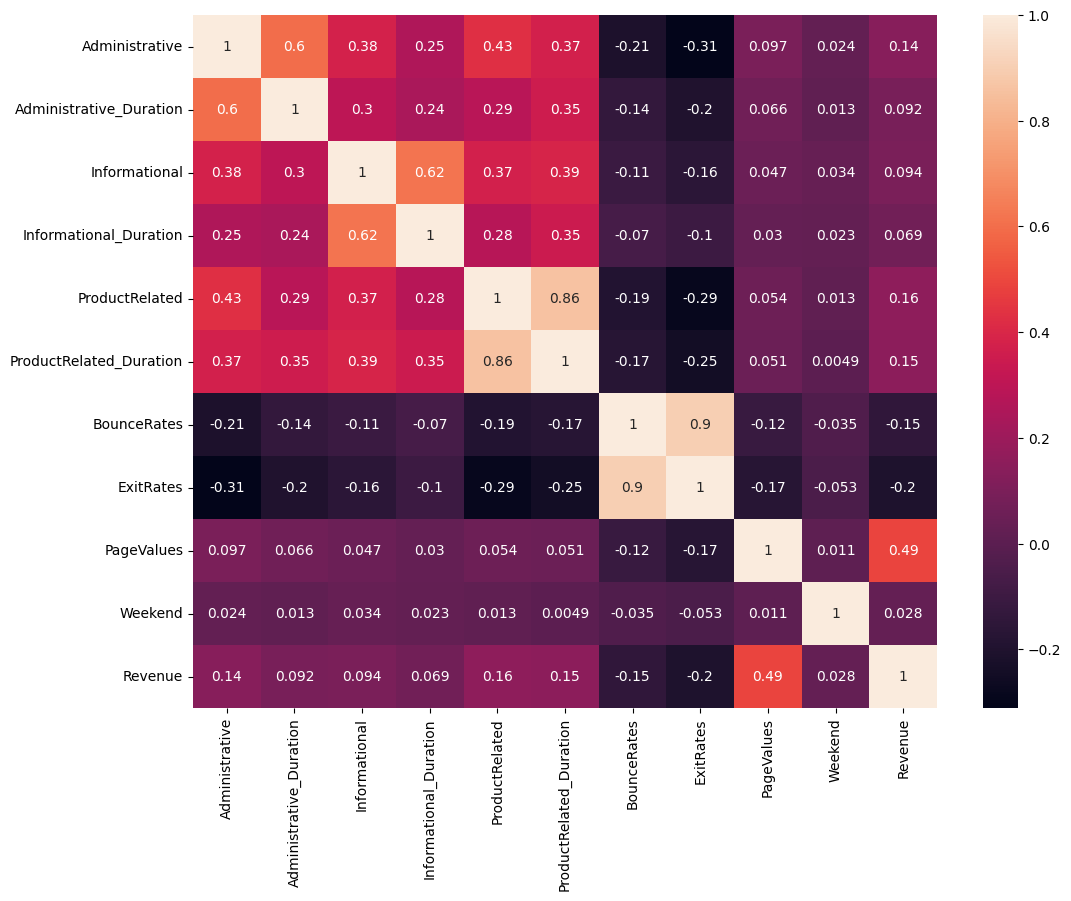

In [198]:
corr = data.corr()
f, ax = plt.subplots(figsize= (12,9))
sns.heatmap(corr, annot= True)

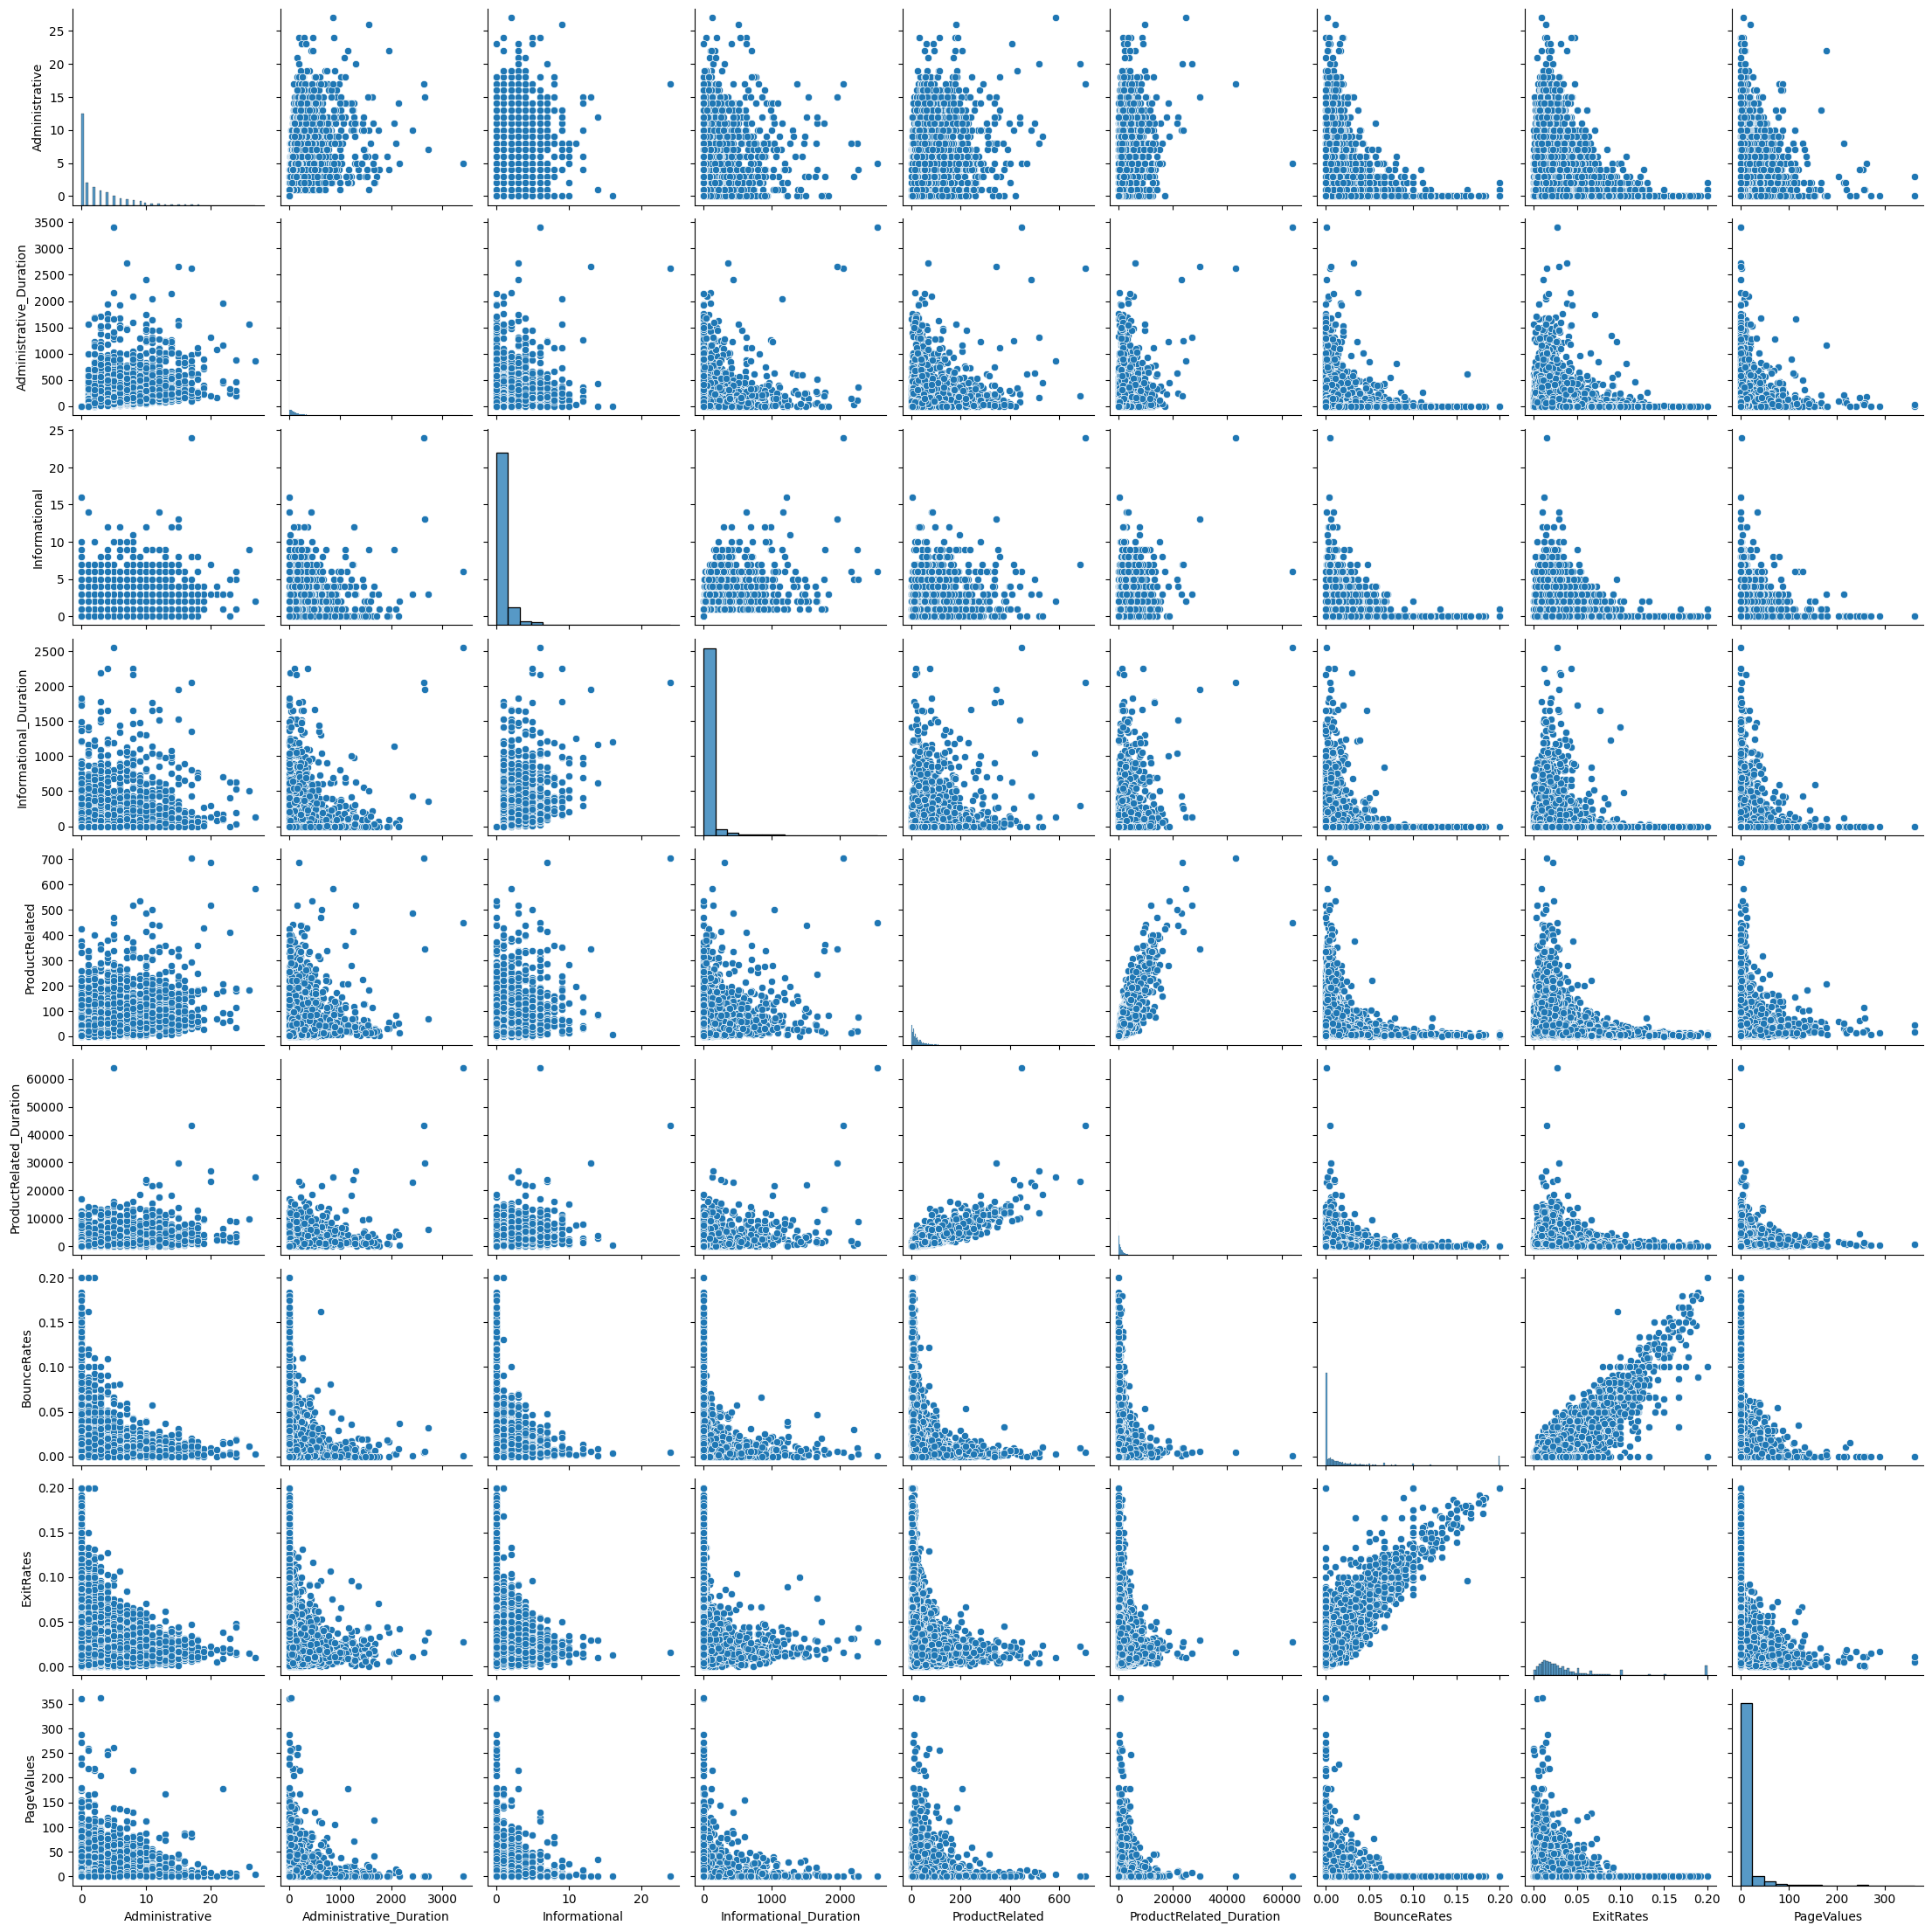

In [199]:
sns.pairplot(data.iloc[:,:-2]);

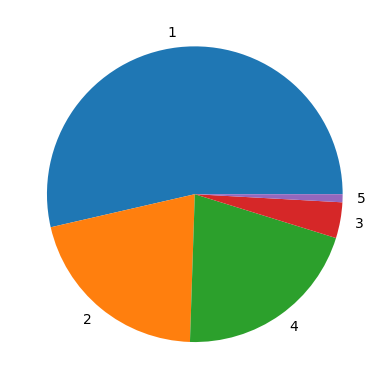

In [200]:
data["OperatingSystems"] = data["OperatingSystems"].replace([5,6,7,8],5)
plt.pie(x= data["OperatingSystems"].value_counts(), labels= data["OperatingSystems"].unique());

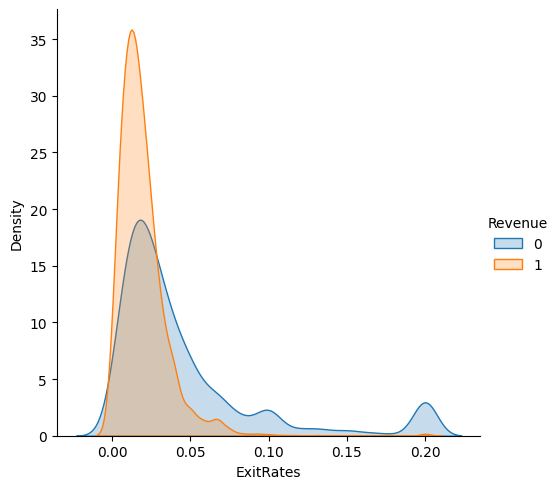

In [201]:
sns.FacetGrid(data, hue= "Revenue", height= 5,).map(sns.kdeplot, "ExitRates", shade= True).add_legend();

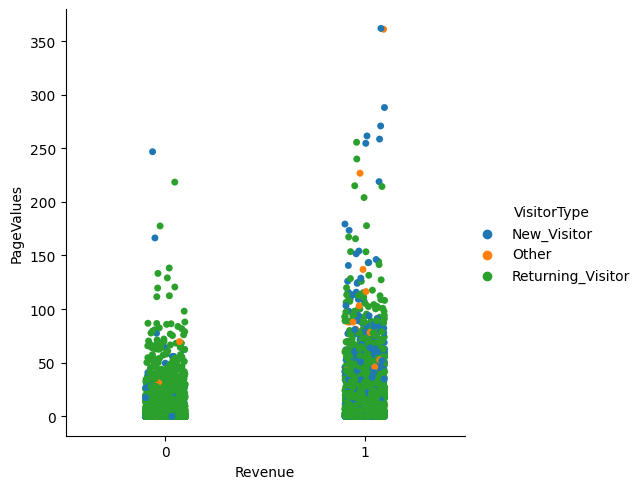

In [202]:
sns.catplot(data= data, x= "Revenue", y= "PageValues", hue= "VisitorType")

<AxesSubplot:xlabel='Revenue', ylabel='SpecialDay'>

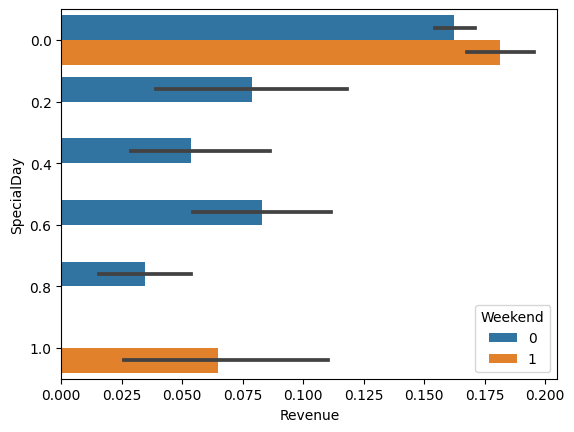

In [203]:
sns.barplot(data=data, x= data["Revenue"], y=data["SpecialDay"], hue = data["Weekend"])

# Data Processing

## Outlier Handling

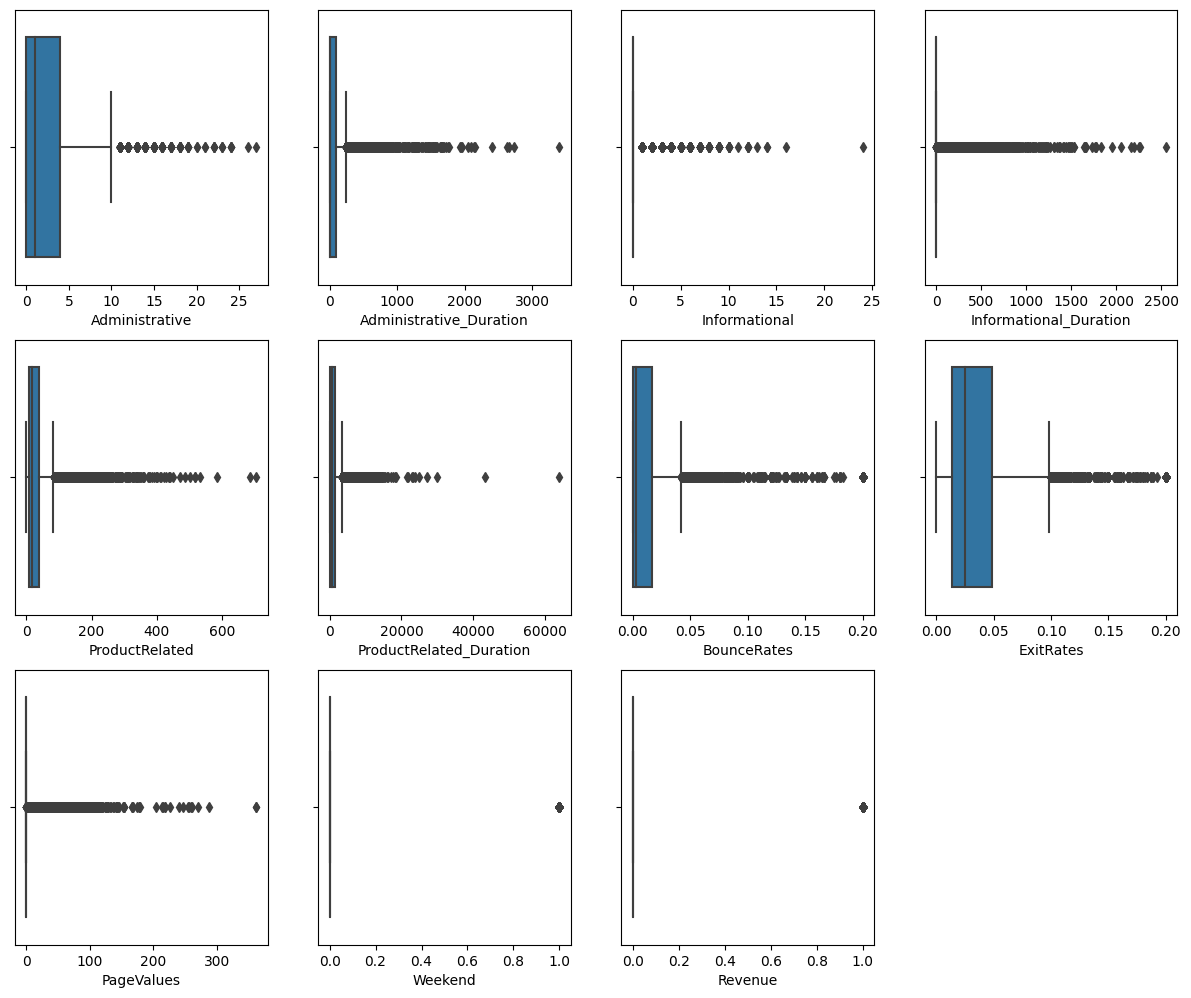

In [204]:
fig = plt.figure(figsize = (15,25))
for i, v in enumerate(data.select_dtypes(include=np.number)): 
    ax = fig.add_subplot(6,4, i+1) 
    sns.boxplot(x = data[v], ax = ax)

### Z-score for Outlier Removing

Z score is also called standard score. This score helps to understand if a data value is greater or smaller than mean and how far away it is from the mean. More specifically, Z score tells how many standard deviations away a data point is from the mean.
If the z score of a data point is more than 3, it indicates that the data point is quite different from the other data points. Such a data point can be an outlier.

In [205]:
data["Revenue"].count

<bound method Series.count of 0        0
1        0
2        0
3        0
4        0
        ..
12200    0
12201    0
12202    0
12203    0
12204    0
Name: Revenue, Length: 12205, dtype: int32>

In [206]:
threshold = 3

for col in data.select_dtypes(include= np.number):
    if col == "Weekend" or col == "Revenue":
        continue
    
    mean = np.mean(data[col])
    std = np.std(data[col])

    for i in range(len(data[col])):
        z = (data[col][i] - mean) / std
        if z > threshold:
            data[col][i] = np.median(data[col])

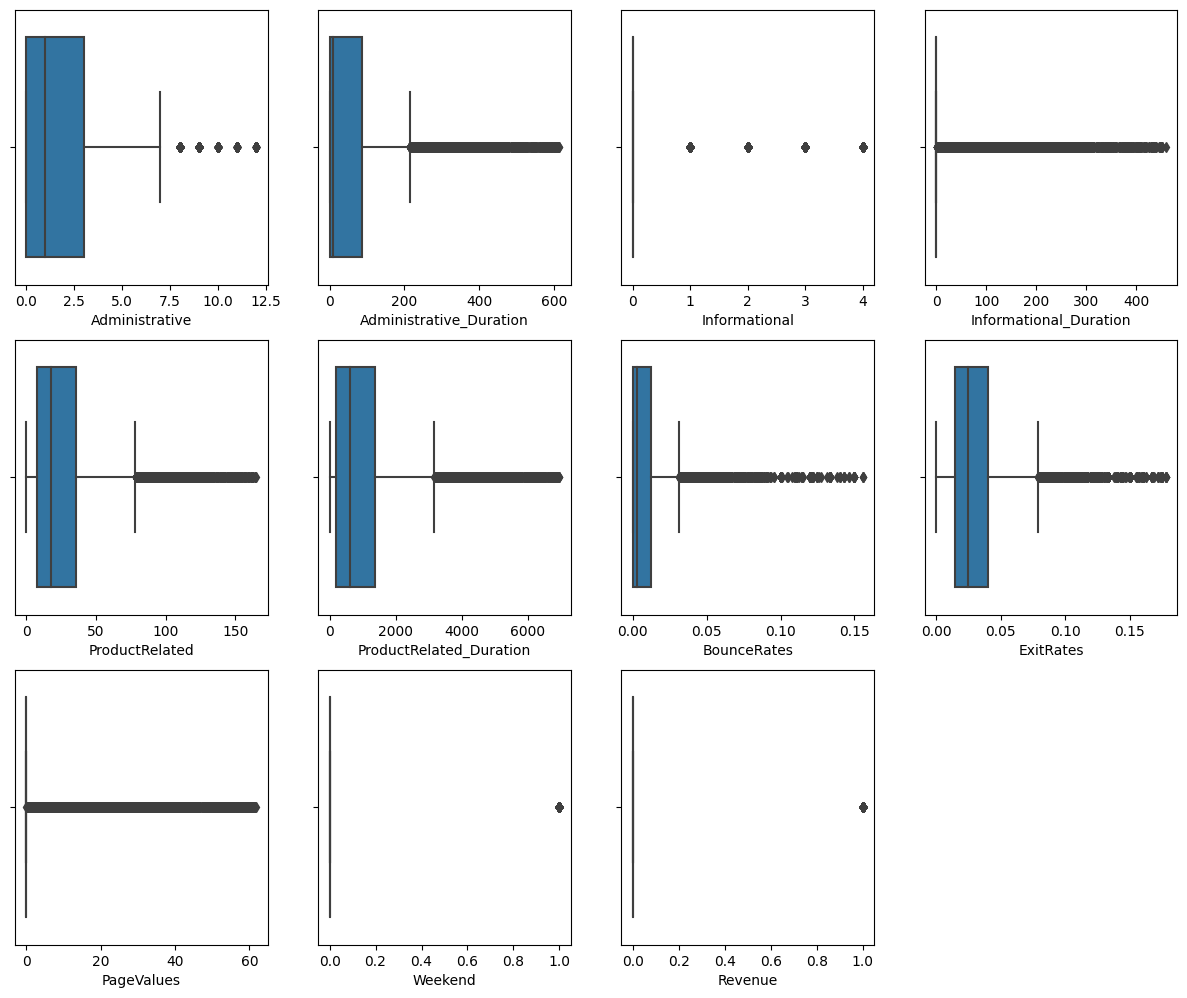

In [207]:
fig = plt.figure(figsize = (15,25))
for i, v in enumerate(data.select_dtypes(include=np.number)): 
    ax = fig.add_subplot(6,4, i+1) 
    sns.boxplot(x = data[v], ax = ax)

As we can see we removed some of the outliers.

In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12205 entries, 0 to 12204
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           12205 non-null  int64   
 1   Administrative_Duration  12205 non-null  float64 
 2   Informational            12205 non-null  int64   
 3   Informational_Duration   12205 non-null  float64 
 4   ProductRelated           12205 non-null  int64   
 5   ProductRelated_Duration  12205 non-null  float64 
 6   BounceRates              12205 non-null  float64 
 7   ExitRates                12205 non-null  float64 
 8   PageValues               12205 non-null  float64 
 9   SpecialDay               12205 non-null  category
 10  Month                    12205 non-null  category
 11  OperatingSystems         12205 non-null  category
 12  Browser                  12205 non-null  category
 13  Region                   12205 non-null  category
 14  Traffi

In [211]:
data = pd.get_dummies(data= data, columns= data.select_dtypes(include= "category").columns)

# Modeling

We will use 3 different Machine Learning algoritm. These are;

* Logistic Regression
* Random Forest Classifier
* Catboost

## Train-test split

In [212]:
X = data.drop("Revenue", axis=1)
y = data["Revenue"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Logistic Regression

For *Logistic Regression* our accuracy is **0.8828**.

In [213]:
loj = LogisticRegression(solver="liblinear")
loj_model = loj.fit(X_train, y_train)

In [214]:
y_pred_loj = loj_model.predict(X_test)

In [215]:
accuracy_score(y_test, y_pred_loj)

0.8828349037279803

In [216]:
print(classification_report(y_test, y_pred_loj))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2059
           1       0.73      0.40      0.51       382

    accuracy                           0.88      2441
   macro avg       0.81      0.68      0.72      2441
weighted avg       0.87      0.88      0.87      2441



In [217]:
confusion_matrix(y_test, y_pred_loj)

array([[2004,   55],
       [ 231,  151]], dtype=int64)

In [218]:
cross_val_score(loj_model, X_test, y_test, cv=10).mean()

0.8807929073268653

## Random Forest Classifier

For *Random Forest Classifier* our accuracy is **0.8930**. 

In [219]:
rf_params = {
    "max_depth" : [30,35,40,45,50],
    "max_features": [0.7, 1, 0.5],
    "n_estimators": [100,300,500,1000,700]
}
rf_model = RandomForestClassifier(random_state = 42)
random_search = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=10, n_jobs = -1)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_score = random_search.best_score_
print(best_params)
print(best_score)

{'max_depth': 35, 'max_features': 0.5, 'n_estimators': 100}
0.8858054935651124


In [231]:
rf_tuned = RandomForestClassifier(n_estimators= 100,  
                                  max_features= 0.5, 
                                  max_depth= 35)



In [232]:
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=35, max_features=0.5)

In [233]:
y_pred_rf = rf_tuned.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.8930766079475625

In [234]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2059
           1       0.72      0.52      0.60       382

    accuracy                           0.89      2441
   macro avg       0.82      0.74      0.77      2441
weighted avg       0.88      0.89      0.89      2441



In [235]:
confusion_matrix(y_test, y_pred_rf)

array([[1983,   76],
       [ 185,  197]], dtype=int64)

## CatBoost

For *CatBoost* our accuracy is **0.8918**.

In [225]:
catb_params = {
    "iterations": [200,300,500],
    "learning_rate": [0.01, 0.05, 0.1],
    "depth": [3, 5, 8]
}
catb = CatBoostClassifier()
catb_model = GridSearchCV(catb, catb_params, cv= 5, n_jobs= -1)
catb_model.fit(X_train, y_train)
catb_model.best_params_

0:	learn: 0.6823392	total: 8.41ms	remaining: 4.2s
1:	learn: 0.6728354	total: 14.8ms	remaining: 3.67s
2:	learn: 0.6635408	total: 22ms	remaining: 3.65s
3:	learn: 0.6541131	total: 28.5ms	remaining: 3.54s
4:	learn: 0.6451566	total: 36.1ms	remaining: 3.58s
5:	learn: 0.6367904	total: 43.8ms	remaining: 3.61s
6:	learn: 0.6282246	total: 51.4ms	remaining: 3.62s
7:	learn: 0.6187493	total: 58.5ms	remaining: 3.6s
8:	learn: 0.6109687	total: 65.6ms	remaining: 3.58s
9:	learn: 0.6028069	total: 73.5ms	remaining: 3.6s
10:	learn: 0.5949481	total: 79.8ms	remaining: 3.55s
11:	learn: 0.5876408	total: 89ms	remaining: 3.62s
12:	learn: 0.5802034	total: 95.9ms	remaining: 3.59s
13:	learn: 0.5725846	total: 103ms	remaining: 3.59s
14:	learn: 0.5658468	total: 110ms	remaining: 3.55s
15:	learn: 0.5587292	total: 119ms	remaining: 3.6s
16:	learn: 0.5523200	total: 126ms	remaining: 3.57s
17:	learn: 0.5459113	total: 132ms	remaining: 3.55s
18:	learn: 0.5396338	total: 139ms	remaining: 3.51s
19:	learn: 0.5333342	total: 146ms	re

{'depth': 5, 'iterations': 500, 'learning_rate': 0.01}

In [236]:
catb_tuned = CatBoostClassifier(depth= 5, iterations= 500, learning_rate= 0.01)
catb_tuned.fit(X_train, y_train)

0:	learn: 0.6823392	total: 5.23ms	remaining: 2.61s
1:	learn: 0.6728354	total: 10.5ms	remaining: 2.62s
2:	learn: 0.6635408	total: 17ms	remaining: 2.82s
3:	learn: 0.6541131	total: 24.3ms	remaining: 3.01s
4:	learn: 0.6451566	total: 30.4ms	remaining: 3.01s
5:	learn: 0.6367904	total: 36.3ms	remaining: 2.99s
6:	learn: 0.6282246	total: 42.5ms	remaining: 3s
7:	learn: 0.6187493	total: 47.8ms	remaining: 2.94s
8:	learn: 0.6109687	total: 53.1ms	remaining: 2.9s
9:	learn: 0.6028069	total: 58.2ms	remaining: 2.85s
10:	learn: 0.5949481	total: 63.6ms	remaining: 2.83s
11:	learn: 0.5876408	total: 69.1ms	remaining: 2.81s
12:	learn: 0.5802034	total: 74.8ms	remaining: 2.8s
13:	learn: 0.5725846	total: 81.1ms	remaining: 2.81s
14:	learn: 0.5658468	total: 87.2ms	remaining: 2.82s
15:	learn: 0.5587292	total: 92.6ms	remaining: 2.8s
16:	learn: 0.5523200	total: 98.7ms	remaining: 2.81s
17:	learn: 0.5459113	total: 105ms	remaining: 2.81s
18:	learn: 0.5396338	total: 111ms	remaining: 2.8s
19:	learn: 0.5333342	total: 117ms

In [237]:
y_pred_catb = catb_tuned.predict(X_test)
accuracy_score(y_test, y_pred_catb)

0.8918476034412126

In [238]:
print(classification_report(y_test, y_pred_catb))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2059
           1       0.71      0.53      0.60       382

    accuracy                           0.89      2441
   macro avg       0.81      0.74      0.77      2441
weighted avg       0.88      0.89      0.89      2441



In [239]:
confusion_matrix(y_test, y_pred_catb)

array([[1975,   84],
       [ 180,  202]], dtype=int64)

### Roc Curve

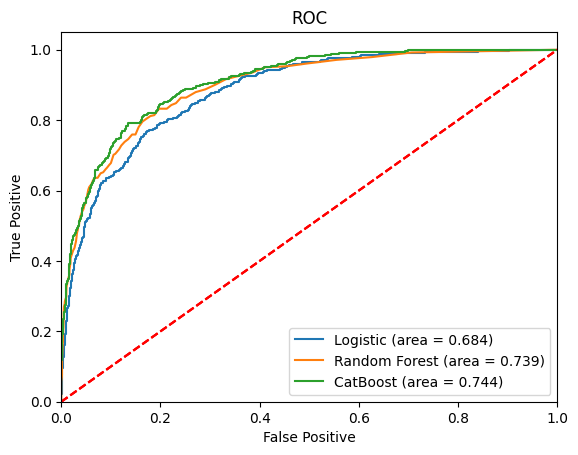

In [240]:
plt.figure().clf()

logit_roc_auc = roc_auc_score(y_test, y_pred_loj)
fpr, tpr, thresholds = roc_curve(y_test, loj_model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label= "Logistic (area = %0.3f)" % logit_roc_auc)
plt.plot([0,1], [0,1], "r--")

rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test, rf_tuned.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label= "Random Forest (area = %0.3f)" % rf_roc_auc)
plt.plot([0,1], [0,1], "r--")

catb_roc_auc = roc_auc_score(y_test, y_pred_catb)
fpr, tpr, thresholds = roc_curve(y_test, catb_tuned.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label= "CatBoost (area = %0.3f)" % catb_roc_auc)
plt.plot([0,1], [0,1], "r--")

plt.legend()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC")
plt.show()